### Sources Used  
[Traffic sign dataset](https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification)  
[Example notebook on traffic sign dataset](https://www.kaggle.com/code/moh3we5/traffic-sign-dataset-resnet-classification)  
[Tensor flow transfer learning documentation](https://www.tensorflow.org/guide/keras/transfer_learning)  
[Tensor flow using GPU](https://saturncloud.io/blog/cant-run-tensorflow-on-gpu-within-jupyternotebook-heres-how-to-fix-it/#:~:text=In%20conclusion%2C%20if%20you%20can,test%20it%20with%20your%20GPU.)  

### Introduction
A Traffic sign dataset will be used, to create a CNN capable of recognizing common traffic signs, these datasets are often used as a component of self driving AI. While most of those implementations tend to use multiple models to narrow down the kind of sign, thereby improving possible classification even with small deviations between similar signs.  
In this notebook a single large model will be trained however.

The dataset used contains 58 classes, covering most common signs, however some classes are labeled as Unkown[n].
For every class ~120 images are present.

In this notebook, transfer learning will be leveraged to obtain a pretrained base model. By using transfer learning, the training process can be greatly reduced and will allow us to utilize layers that have been trained on much larger datasets than the one used here.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import pandas as pd

from tensorflow import keras

Load in the traffic sign dataset

In [2]:
dataset_directory = "Dataset/traffic_Data/DATA/"
labels_path = "Dataset/labels.csv"

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(dataset_directory, labels='inferred', seed=123)

Found 4170 files belonging to 58 classes.


In [4]:
dataset.class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '6',
 '7',
 '8',
 '9']

Due to the dataset using an index for its labels, a conversion has to be made to convert the index labels to the human readable labels

In [5]:
original_class_names = dataset.class_names
csv_labels = pd.read_csv(labels_path)
csv_labels_dict = classid_to_name = dict(zip(csv_labels['ClassId'], csv_labels['Name']))
def relabel(label):
    return csv_labels_dict[int(label)]

Now lets take a look at the dataset with the human readable labels

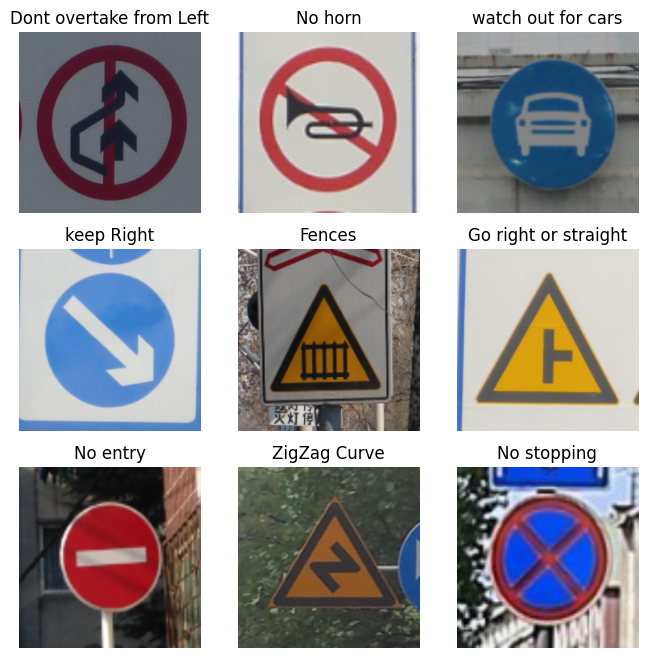

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(relabel(original_class_names[labels[i]]))
        plt.axis("off")

First, obtain a pre trained model, this can be done via the tensorflow keras API.  
Here we specify a model that has its weights trained on the ImageNet dataset, the expected image input size and that the classification top layer should be excluded

In [7]:
pretrained_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(71, 71, 3), # Input shape of our dataset images
    classes=original_class_names,
    include_top=False)  # Exclude the classifier layer, as our own will be used

Block the pretrained layers/base-model from having its weights changed during training

In [8]:
pretrained_model.trainable = False

Now, lets create our own model

In [15]:
model = keras.Sequential(
    [
        keras.Input(shape=(71, 71, 3)),
        keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
        pretrained_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(len(original_class_names)),
    ])

# inputs = keras.Input(shape=(71, 71, 3))

# # Add normalizer layer scale to change the image data from 0-255 to -1-1
# scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
# x = scale_layer(x)

# x = pretrained_model(inputs, training=False)
# # Convert features of shape `base_model.output_shape[1:]` to vectors
# x = keras.layers.GlobalAveragePooling2D()(x)
# # A Dense classifier with a single unit (binary classification)
# outputs = keras.layers.Dense(len(original_class_names))(x)
# model = keras.Model(inputs, outputs)

Lets take a quick look at the internal layers of the pretrained model and our model

In [16]:
pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 71, 71, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 35, 35, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 35, 35, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 35, 35, 32)           0         ['block1_conv1_bn[0][0]

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 71, 71, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 58)                118842    
                                                                 
Total params: 20980322 (80.03 MB)
Trainable params: 118842 (464.23 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


Now lets get our train and validation datasets.  
These datasets will be split 8:2, the images given are however not normalized with a large range of image sizes, from 72x62 to 265x265

In [18]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory, 
    labels="inferred",
    subset="training",
    seed=123,
    validation_split=0.2)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory, 
    labels="inferred",
    subset="validation",
    seed=123,
    validation_split=0.2)

Found 4170 files belonging to 58 classes.
Using 3336 files for training.
Found 4170 files belonging to 58 classes.
Using 834 files for validation.


Normalize the images  
(71x71 is chosen, as this is the minimum input size allowed for the pretrained xception model, so keeping the input the same will hopefully allow for a better result than downsampling the input even further)

In [19]:
size = (71, 71)

train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, size), y))

Lets train this new model

In [21]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


105/105 [==============================] - 36s 313ms/step - loss: 0.4040 - accuracy: 0.9068 - val_loss: 0.3339 - val_accuracy: 0.9029
Epoch 2/10
105/105 [==============================] - 33s 315ms/step - loss: 0.1748 - accuracy: 0.9667 - val_loss: 0.2228 - val_accuracy: 0.9424
Epoch 3/10
105/105 [==============================] - 36s 342ms/step - loss: 0.1079 - accuracy: 0.9838 - val_loss: 0.1640 - val_accuracy: 0.9700
Epoch 4/10
105/105 [==============================] - 35s 331ms/step - loss: 0.0745 - accuracy: 0.9925 - val_loss: 0.1378 - val_accuracy: 0.9796
Epoch 5/10
105/105 [==============================] - 37s 346ms/step - loss: 0.0582 - accuracy: 0.9943 - val_loss: 0.1137 - val_accuracy: 0.9856
Epoch 6/10
105/105 [==============================] - 35s 331ms/step - loss: 0.0430 - accuracy: 0.9967 - val_loss: 0.1071 - val_accuracy: 0.9856
Epoch 7/10
105/105 [==============================] - 34s 318ms/step - loss: 0.0354 - accuracy: 0.9982 - val_loss: 0.0988 - val_accuracy: 0.9

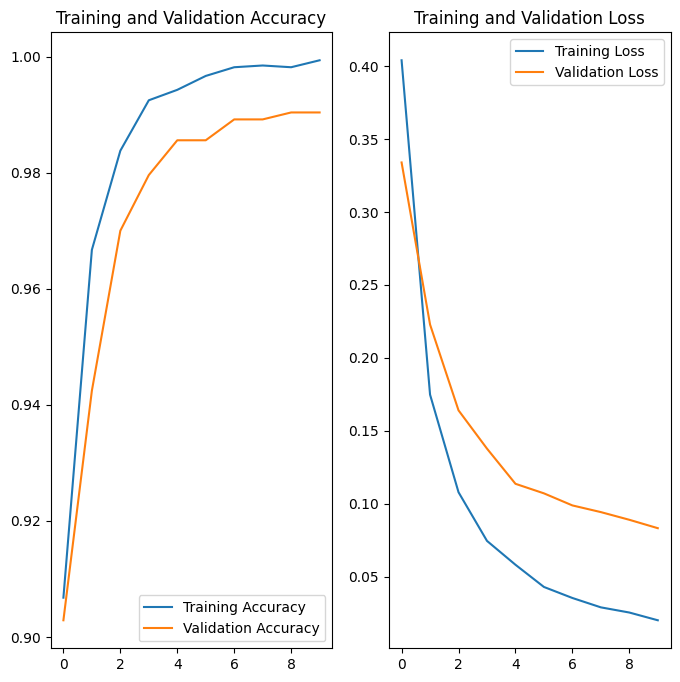

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

While the extremely high accuracy could indicate overfitting, the growth and consistent gap between training and validating dataset looks very promising (although this could be an indicator of overfitting)

Now lets get a test dataset to evaluate the model

In [23]:
test_directory = 'Dataset/traffic_Data/TEST/'

The test images aren't stored in the same tensorflow structure as the train/val data, so extra processing will have to be done.
The images are all in a single folder, with the label being encoded as the first number in the file name (e.g. xxx_0000.png)

In [24]:
def load_test_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)  # decode image into RGB channels
    img = tf.image.resize(img, (71, 71))  # Resize image to 71x71 just as the training set

    return img

def extract_label(file_path):
     # Split the file_path based on the directory separator ("/" or "\")
    parts = tf.strings.split(file_path, '\\')
    # Select the last part, which is the file name
    file_name = parts[-1]

    # Get numerical chars from the filename before the _ char
    label = tf.strings.regex_replace(file_name, r'^(.*?)_.+$', r'\1')
    
    return label

In [25]:
test_image_paths = tf.data.Dataset.list_files(test_directory + '*.png')

test_dataset = test_image_paths.map(lambda x: (load_test_image(x), int(extract_label(x))))

In [26]:
# Batch and prefetch the dataset
batch_size = 32
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Lets see if I properly loaded in the testdata, as this took a significant amount of messing around

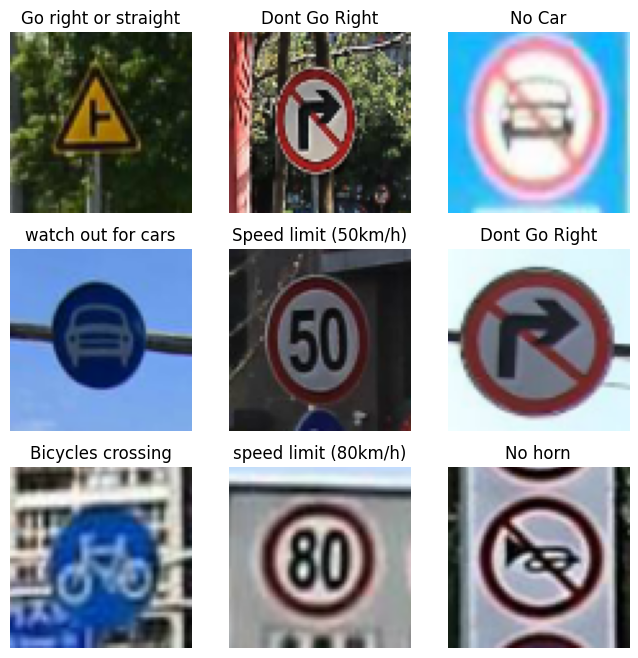

In [27]:
plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(relabel(labels[i]))
        plt.axis("off")

Lets resize the test dataset just as done with the train and val datasets

In [44]:
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, size), y))

Now we can evaluate the model based on the test dataset

In [45]:
metrics = model.evaluate(test_dataset, verbose=1)

63/63 [==============================] - 15s 233ms/step - loss: 13.7079 - accuracy: 0.0191


Well, an accuracy of 0.0191 was definitely not expected... This might indicate that the model is extremely overfitted. However, there is still a massive deviation between the validation accuracy and the testing accuracy here (validation accuracy was still ~99%)

In [43]:
# img = tf.keras.utils.load_img(
#     test_directory+"003_0035.png", target_size=(71, 71)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])
# print(np.argmax(score))
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(relabel(np.argmax(score)), 100 * np.max(score))
# )

1/1 [==============================] - 0s 70ms/step
45
This image most likely belongs to Unknown4 with a 94.28 percent confidence.
